# Benchmark M3.1: A Single Root in a Static Soil

by Daniel Leitner, Andrea Schnepf, Felicien Meunier

##Comparison to numerical solutions

We compare different numerical codes by solving the benchmarking problems. In the following we link to notebooks implement Benchmark M3.1.

    [Python Code from Schnepf et al. 2018](Xylem flux - Python code.ipynb)
    [Dumux](Xylem flux - Dumux.ipynb)

For an automatic comparison of the numerical results, save the results in a text file with two lines, containing comma separated depth values [cm] in the first line, and pressure head [cm] in the second, located in the folder `/M31 Numerical results/simulatorname`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import *

In [2]:
L = 50            # length of single straight root [cm]
a = 0.2           # radius  [cm]
kx = 0.173        # axial conductivity [cm^3 / day] 
kr = 2.6e-3       # radial conductivity [1 / day]
p_s = -200        # static soil matric potiential [cm]
p0 = -1000        # dirichlet bc at top [cm]

In [3]:
# Analytical solution
c = 2*a*pi*kr/kx
p_r = lambda z: p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z)

# Boundary conditions
AA = np.array([[1,1], [sqrt(c)*exp(sqrt(c)*(-L)), -sqrt(c)*exp(-sqrt(c)*(-L))] ]) 
bb = np.array([p0-p_s, -1]) 
d = np.linalg.solve(AA, bb) 

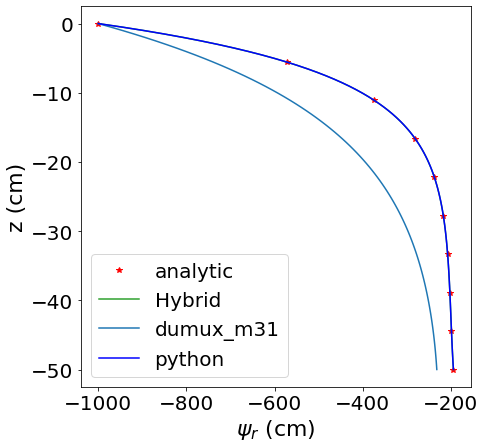

Name		 N	 Rsme		 R²		 R
Hybrid		 101 	 0.00000000 	 1.00000313 	 1.00000000
dumux_m31		 100 	 199598796.87164408 	 1.08246905 	 0.93253519
python		 100 	 0.00001377 	 1.00021524 	 0.99999997


In [5]:
fig=plt.figure(figsize=(7,7))   # analytical solution
y = np.linspace(0,-50,10)
plt.plot(list(map(p_r, y)),y,"r*")

j = 0 # number of files
r, rsme, rsquare, nn = [], [], [], []
col=["C2","C0","b"]
l = ["analytic"]
for dirname, dirnames, filenames in os.walk('M31 Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            l.append(f)
            data = np.loadtxt("M31 Numerical results/"+f,delimiter=',')
            plt.plot(data[1,:],data[0,:],col[i]) # numeric solution         
            j += 1     
            # Evaluate
            n = len(data[1,:])
            nn.append(n)
            pr_ = list(map(p_r, data[0,:])) # exact solution at data depth points  
            # calculate R
            om = np.mean(data[1,:])
            pm = np.mean(pr_)
            r_ =  np.sum((data[1,:]-om)*(pr_-pm)) / (np.sqrt(np.sum(np.square(data[1,:]-om)))*np.sqrt(np.sum(np.square(pr_-pm))) )
            r.append(r_*r_)
            # calculate R^2
            meany = np.mean(data[1,:])
            r2 = np.sum(np.square(pr_-meany)) / np.sum(np.square(data[1,:]-meany))                         
            rsquare.append(r2)            
            # calculate RSME
            rsme_ = np.square(np.sum(np.square(data[1,:]-pr_)/n))
            rsme.append(rsme_)                
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)            
plt.xlabel("$\\psi_r$ (cm)")
plt.ylabel("z (cm)")
plt.legend(l)
#plt.xticks(np.arange(-6,4,3))
#plt.yticks(np.arange(-16,1,4))
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
#plt.savefig('m31_results.png', dpi=300, bbox_inches = "tight")
plt.show()
print("Name\t\t", "N\t", "Rsme\t\t", "R²\t\t", "R")
for i in range(0,j):
    print(l[i+1]+"\t\t",nn[i],"\t",'{:2.8f}'.format(rsme[i]),"\t", '{:2.8f}'.format(rsquare[i]),"\t",'{:2.8f}'.format(r[i]) ) 

## References

Doussan, C., Pierret, A., Garrigues, E., and Pages, L. (2006). Water uptake by plant roots: II - Modelling of water transfer in the soil root-system with explicit account of flow within the root system - comparison with experiments. *Plant and Soil*, 283(1-2):99–117.

Roose, T. and Fowler, A. C. (2004). A model for water uptake by plant roots. *Journal of Theoretical Biology*, 228(2):155–171.

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053
